In [14]:
# Import modules

import matplotlib.pyplot as plt
import os
from LaceyClass import LaceyMixingAnalyzer
from extrapolation import extrapolation
import numpy as np

# Initialise variables and call class
simulation = os.path.abspath(os.path.join("..", '..', 'data', "rot_drum", "JKR_periodic_clean", "Rot_drum.dem"))
sim_path = os.path.dirname(simulation)

#simulation parameters
start_t = 1
end_t = 45
domain_x = (-0.06, 0.06)       
domain_y = (-0.015, 0.015)
domain_z = (-0.06, 0.06)
num_bins = 4
direction = "y"

extrap = extrapolation(start_t, end_t, simulation, domain_x, domain_y, domain_z, num_bins, direction)

# #simulation parameters
# start_t = 1
# end_t = 10

# # simulations and their properties
# simulation_settings = {
#     "1": {
#         "domain_x": (-0.06, 0.06),
#         "domain_y": (-0.015, 0.015),
#         "domain_z": (-0.06, 0.06),
#         "num_bins": 4,
#         "direction": "y",
#         "path": os.path.abspath(os.path.join("..", '..', 'data', "rot_drum", "JKR_periodic_clean", "Rot_drum.dem")),
#     },
#     "2": {
#         "domain_x": (-0.07, 0.07), 
#         "domain_y": (-0.025, 0.025), 
#         "domain_z": (-0.07, 0.07), 
#         "num_bins": 10,  
#         "direction": "y",
#         "path": os.path.abspath(os.path.join("..", '..', "Rot_drum", "HM_10rpm_100k", "Rot_drum.dem")),
#     }
# }

# #choose simulation
# simulation = simulation_settings["1"]
# domain_x, domain_y, domain_z, num_bins, direction, simulation_path = simulation.values()
# sim_path = os.path.dirname(simulation_path)
# extrap = extrapolation(start_t, end_t, simulation_path, domain_x, domain_y, domain_z, num_bins, direction)



Analysing Kinetic Energies...


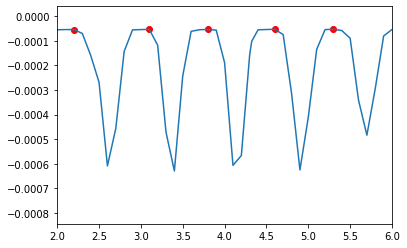

In [15]:

kinetic_energies, peak_times, peak_index, highlight_y = extrap.kin_energies(0.0002, 5)
plt.figure()
kin_e = np.column_stack((extrap.deck.timestepValues[extrap.start:], kinetic_energies))
plt.plot(kin_e[:,0], kin_e[:,1])

plt.scatter(peak_times, highlight_y, c="red")
x = (2,6)
plt.xlim(left=x[0], right=x[1])

time_diff_zeros = np.zeros_like(peak_times)
time_diff = np.diff(peak_times)
time_diff_zeros[1:] = time_diff
#print(np.column_stack((peak_index, peak_times, time_diff_zeros)))

In [16]:
len(kinetic_energies)==len(extrap.deck.timestepValues[extrap.start:])

True

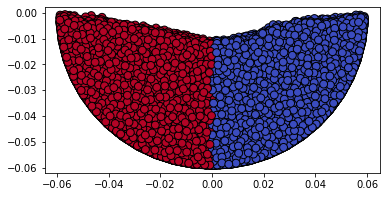

In [17]:
# Plot starting position

id_dict = extrap.id_dictionary(extrap.sim_time[0])
init_particles = extrap.get_particle_coords(extrap.sim_time[0])
plt.figure()
extrap.plot_particles(init_particles, id_dict, True)
plt.show()

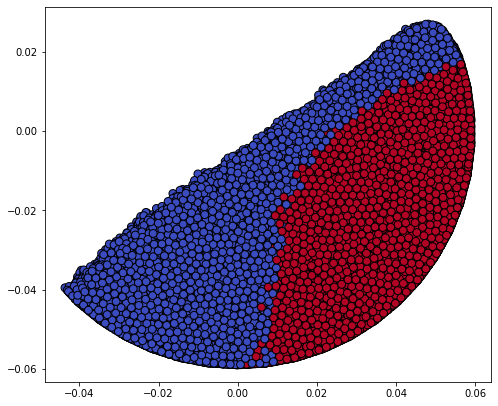

In [18]:
# Plot peak index 3 normal

plt.figure(figsize=(8,12))
actual_3 = extrap.plot_particles(extrap.get_particle_coords(peak_index[3]), id_dict, True)


In [19]:
extrap.deck.timestepValues[peak_index[49]]

39.60000007068532

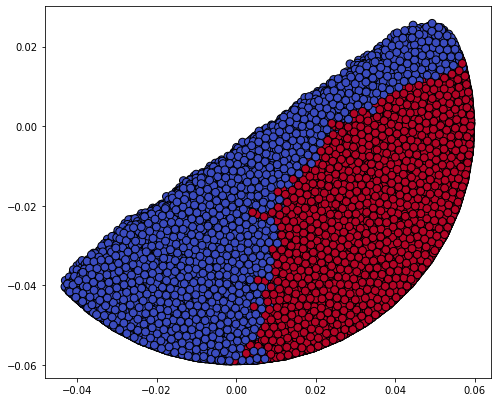

In [21]:
pos_dict_split = extrap.import_dict(sim_path, "peak23_4y_split")
plt.figure(figsize=(8,12))
ex_3 = extrap.plot_particles(extrap.extrapolate_particles(extrap.get_particle_coords(peak_index[2]), pos_dict_split), id_dict, True)

21061


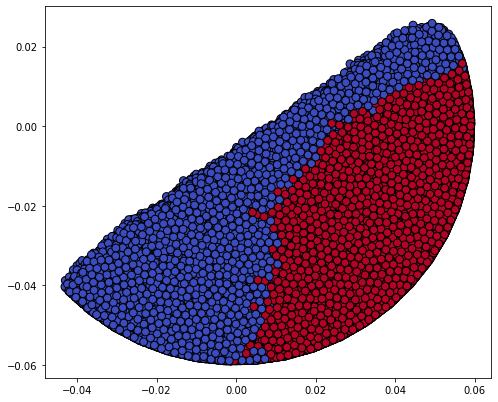

In [22]:
pos_dict = extrap.import_dict(sim_path, "peak23")
print(len(pos_dict))

plt.figure(figsize=(8,12))
ex_3 = extrap.plot_particles(extrap.extrapolate_particles(extrap.get_particle_coords(peak_index[2]), pos_dict), id_dict, True)


In [23]:
# Find keys with differing values
differing_entries = {key: (pos_dict_split[key], pos_dict[key]) for key in pos_dict_split if pos_dict_split[key] != pos_dict[key]}

print(f"{len(differing_entries)} different particle pairs ({len(differing_entries)/len(pos_dict)*100:.2f}%)")

5180 different particle pairs (24.60%)


In [24]:
#get Lacey settings

with open(os.path.abspath(os.path.join("Lacey_settings.txt")), 'r') as file:
    preferences = file.readlines()
    minCoords = np.array([float(i) for i in str(preferences[1]).split(',')])
    maxCoords = np.array([float(i) for i in str(preferences[3]).split(',')])
    bins = np.array([int(i) for i in str(preferences[5]).split(',')])
    cut_off = float(preferences[7])
    plot = str(preferences[9])
    file.close()
    settings = True

lacey = LaceyMixingAnalyzer(minCoords, maxCoords, bins, simulation)

In [25]:
Lacey_index = np.zeros(lacey.deck.numTimesteps)
b_coords, div_size = lacey.grid()
cut_off = 0.001

get_lacey = False

if get_lacey:
    for i in extrap.sim_time:
            particles = extrap.plot_particles(extrap.get_particle_coords(i), id_dict, 0)

            mass_1, mass_2, conc = lacey.bining(b_coords, div_size, particles, cut_off)

            Lacey_index[i] = lacey.Lacey(mass_1, mass_2, conc, cut_off, len(particles))
            print("Timestep: " + str(lacey.deck.timestepValues[i]) + " (s)")


            if i == extrap.sim_time[-1]: 
                if plot == 'yes\n':
                    time = lacey.deck.timestepValues
                    lacey.render(particles, b_coords, "test", Lacey_index, time, div_size, simulation)
                lacey.write_out(Lacey_index, time, simulation, "test")


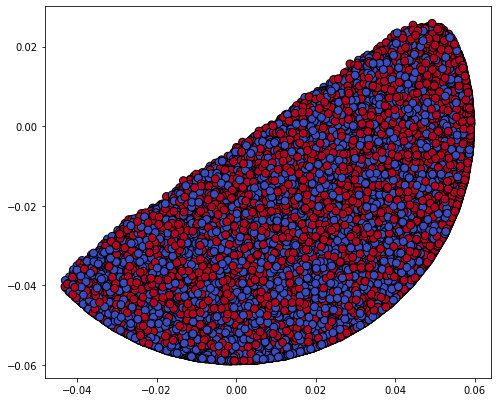

In [34]:
predicted_old = extrap.plot_particles(extrap.get_particle_coords(peak_index[2]), id_dict, 0)
extrapolated_lacey = []
init_time = peak_times[2]
extrapolated_time = [init_time]
limit = 60


for i in range(limit):
    if i == limit-1:
        plt.figure(figsize=(8,12))
        predicted_new = extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 1)
        plt.show()
    else:
        predicted_new = extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 0)
        mass_1, mass_2, conc = lacey.bining(b_coords, div_size, predicted_new, cut_off)

        Lacey_index = lacey.Lacey(mass_1, mass_2, conc, cut_off, len(predicted_new))
        extrapolated_lacey.append(Lacey_index)
        new_time = extrapolated_time[-1]+0.8
        extrapolated_time.append(new_time)
        #print(Lacey_index, new_time)
        predicted_old = predicted_new

array([[ 4.58999954e-02, -6.26802269e-03,  2.12974179e-02,
         1.04719755e-05,  1.90840000e+04,  1.00000000e+00],
       [ 3.07047402e-03, -1.22812764e-02, -3.49475498e-02,
         1.04719755e-05,  1.60330000e+04,  1.00000000e+00],
       [ 1.22387321e-02, -1.07776025e-02, -2.76971932e-02,
         1.04719755e-05,  9.30600000e+03,  1.00000000e+00],
       ...,
       [ 4.55532750e-02,  1.40073168e-02,  8.32919466e-03,
         1.04719755e-05,  2.10000000e+03,  1.00000000e+00],
       [ 2.33540458e-02,  1.40115051e-02, -1.31292035e-02,
         1.04719755e-05,  1.53850000e+04,  1.00000000e+00],
       [ 1.75263671e-02,  1.40048098e-02, -4.98713468e-03,
         1.04719755e-05,  1.88690000e+04,  1.00000000e+00]])

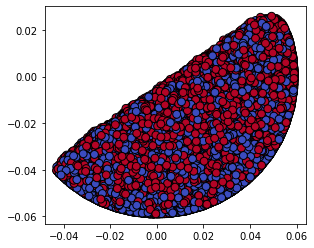

In [35]:
extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 1)

In [36]:
directory_path = sim_path

# Initialize an empty list to store the NumPy arrays
Lacey_actual = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('test_Report.csv'):  # Check if the file is a CSV file
        file_path = os.path.join(directory_path, filename)
        data = np.genfromtxt(file_path, delimiter=',', skip_header=0)  # Assuming CSV has headers
        Lacey_actual.append(data)

Lacey_actual = np.array(Lacey_actual)[0]

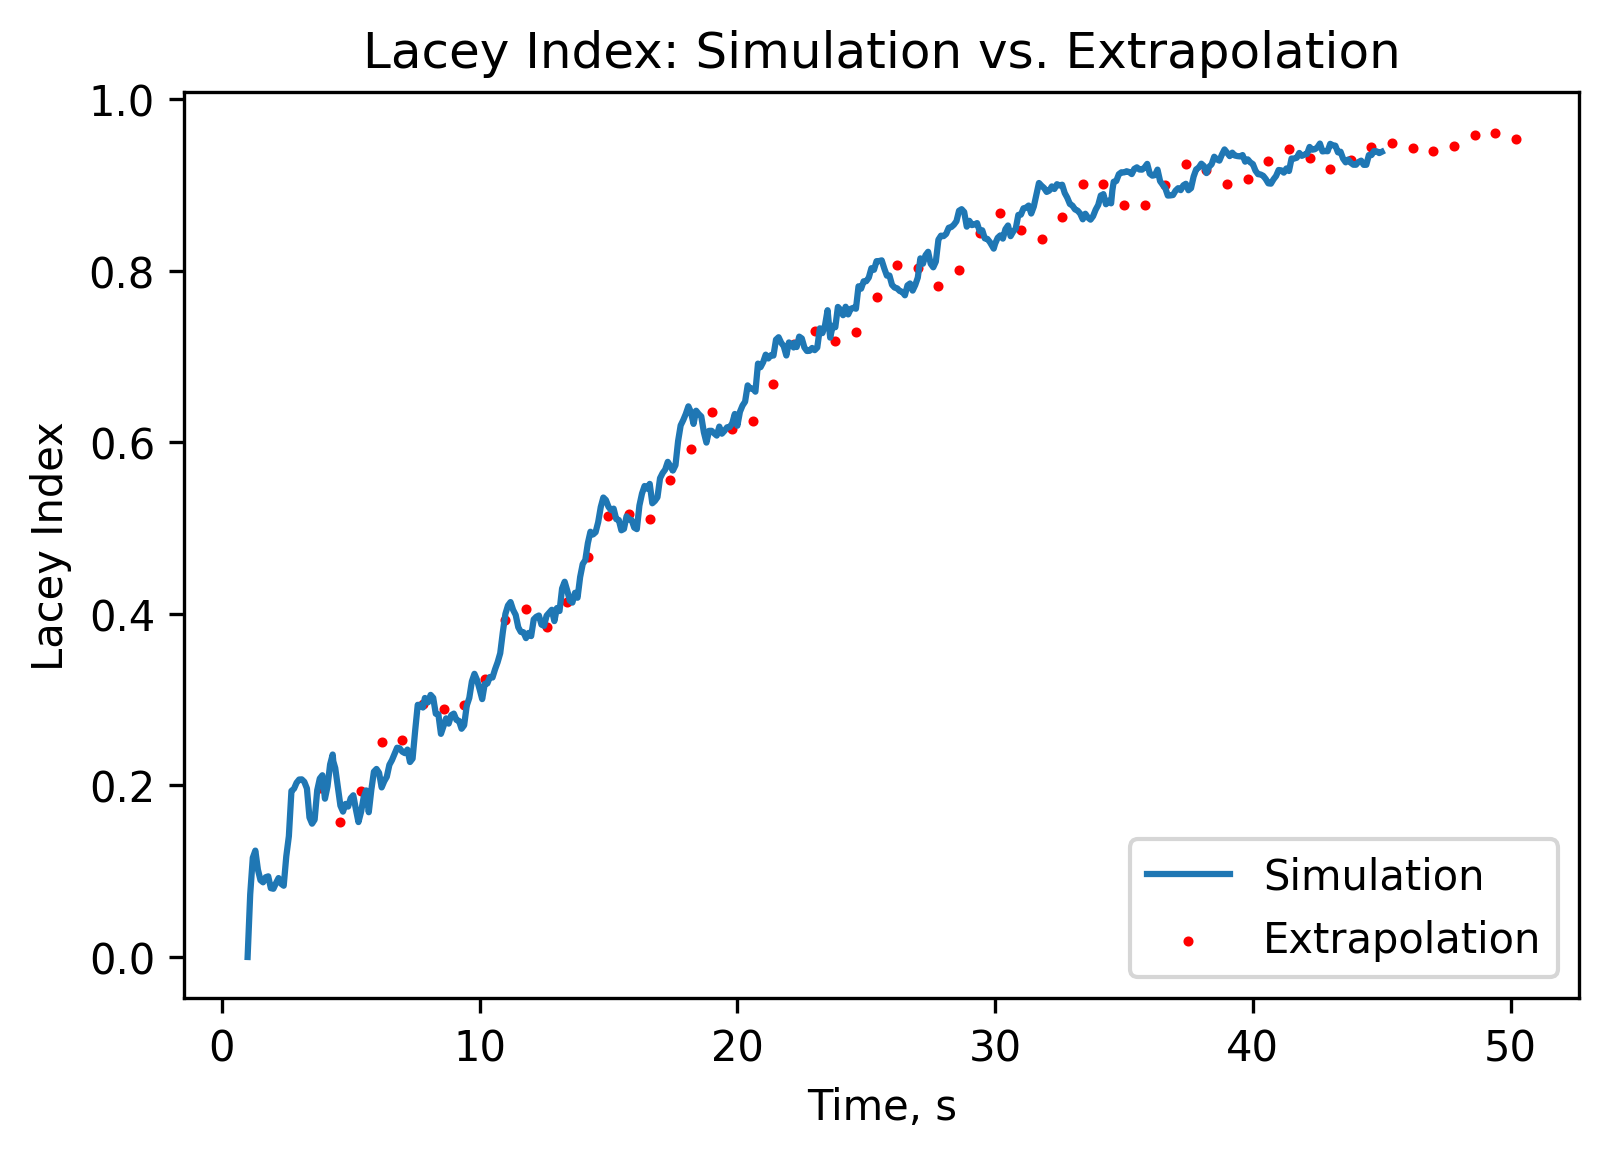

In [37]:
plt.figure(dpi=300)
plt.plot(extrap.deck.timestepValues[extrap.start:], Lacey_actual[extrap.start:, 1], label = "Simulation")
plt.scatter(extrapolated_time[:-1], extrapolated_lacey, c="red", s=2, label = "Extrapolation")

plt.xlabel('Time, s')
plt.ylabel('Lacey Index')
plt.title('Lacey Index: Simulation vs. Extrapolation')
plt.legend(loc="lower right")